# Import

In [5]:
import numpy as np
import os
import cv2
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform, AffineTransform

# Suppress the specific warning
import warnings
import csv
import sys
from IPython.utils.capture import capture_output
from datetime import datetime
from tqdm import tqdm

import torch
from torchvision import transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils import data

from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from utils.utils0 import *
from utils.utils0 import transform_to_displacement_field
from utils.utils1 import *
from utils.utils1 import ModelParams, DL_affine_plot, loss_extra

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

# Stub to warn about opencv version.
if int(cv2.__version__[0]) < 3: # pragma: no cover
  print('Warning: OpenCV 3 is not installed')

image_size = 256


Device: cuda


## Cases, model parameters
- Supervised DL w/ groundtruth affine transformation parameters (MSE params, MSE, NCC images)
    - Synthetic eye
    - Synthetic shape
- Unsupervised DL (MSE, NCC images)
    - Actual eye data
    - Synthetic eye
    - Synthetic shape
- Data
    - only images
    - only heatmaps
    - images & heatmaps
- Loss function
    - MSE affine parameters
    - MSE, NCC images

    

In [6]:
model_params = ModelParams(sup=1, dataset=1, image=1, heatmaps=0, 
                           loss_image=2, num_epochs=1)
model_params.print_explanation()

Model name:  dataset1_sup1_image1_heatmaps0_loss_image2
Model code:  11102_0.001_0_1_1
Model params:  {'dataset': 1, 'sup': 1, 'image': 1, 'heatmaps': 0, 'loss_image_case': 2, 'loss_image': <utils.utils1.MSE_SSIM object at 0x7fc9e87118b0>, 'loss_affine': <utils.utils1.loss_affine object at 0x7fc9e87116a0>, 'learning_rate': 0.001, 'decay_rate': 0.96, 'start_epoch': 0, 'num_epochs': 1, 'batch_size': 1, 'model_name': 'dataset1_sup1_image1_heatmaps0_loss_image2'}

Model name:  dataset1_sup1_image1_heatmaps0_loss_image2
Model code:  11102_0.001_0_1_1
Dataset used:  Synthetic eye
Supervised or unsupervised model:  Supervised
Image type:  Image used
Heatmaps used:  Heatmaps not used
Loss function case:  2
Loss function for image:  <utils.utils1.MSE_SSIM object at 0x7fc9e87118b0>
Loss function for affine:  <utils.utils1.loss_affine object at 0x7fc9e87116a0>
Learning rate:  0.001
Decay rate:  0.96
Start epoch:  0
Number of epochs:  1
Batch size:  1




# Models
## SuperPoint

In [7]:
from utils.SuperPoint import SuperPointFrontend

## ImgReg Network

In [8]:
from utils.SPaffineNet import AffineNet

## SP ImgReg model

In [ ]:
# define model
class SP_AffineNet(nn.Module):
    def __init__(self):
        super(SP_AffineNet, self).__init__()
        self.superpoint = SuperPointFrontend('utils/superpoint_v1.pth', nms_dist=4,
                          conf_thresh=0.015, nn_thresh=0.7, cuda=True)
        self.affineNet = AffineNet()
        self.nn_thresh = 0.7

    def forward(self, source_image, target_image):
        # source_image = source_image.to(device)
        # target_image = target_image.to(device)

        # print('source_image: ', source_image.shape)
        # print('target_image: ', target_image.shape)
        points1, desc1, heatmap1 = self.superpoint(source_image[0, 0, :, :].cpu().numpy())
        points2, desc2, heatmap2 = self.superpoint(target_image[0, 0, :, :].cpu().numpy())

        if model_params.heatmaps == 0:
            affine_params = self.affineNet(source_image, target_image)
        elif model_params.heatmaps == 1:
            affine_params = self.affineNet(source_image, target_image, heatmap1, heatmap2)

        transformed_source_affine = tensor_affine_transform(source_image, affine_params)

        # match the points between the two images
        tracker = PointTracker(5, nn_thresh=0.7)
        try:
            matches = tracker.nn_match_two_way(desc1, desc2, nn_thresh=self.nn_thresh)
        except:
            print('No matches found')
            # TODO: find a better way to do this
            try:
                while matches.shape[1] < 3 and self.nn_thresh > 0.1:
                    self.nn_thresh = self.nn_thresh - 0.1
                    matches = tracker.nn_match_two_way(desc1, desc2, nn_thresh=self.nn_thresh)
            except:
                return transformed_source_affine, affine_params, [], [], [], [], [], [], []

        # take the elements from points1 and points2 using the matches as indices
        matches1 = points1[:2, matches[0, :].astype(int)]
        matches2 = points2[:2, matches[1, :].astype(int)]

        # transform the points using the affine parameters
        displacement_field = torch.zeros(source_image.size(0), source_image.size(1)).to(device)
        DVF_affine = transform_to_displacement_field(
                    displacement_field.view(1, 1, displacement_field.size(0), displacement_field.size(1)),
                    affine_params, device=device)

        matches1_transformed = ops.landmark_transformer2(matches1, DVF_affine.cpu())

        return transformed_source_affine, affine_params, matches1, matches2, matches1_transformed, desc1, desc2, heatmap1, heatmap2

        # return transformed_source_affine, affine_params

        


# Load data

In [9]:
from utils.datagen import datagen

# Training
## Dataset initialization

In [10]:
train_dataset = datagen(model_params.dataset, True, model_params.sup)
test_dataset = datagen(model_params.dataset, False, model_params.sup)

# Get sample batch
print('Train set: ', [x.shape for x in next(iter(train_dataset))])
print('Test set: ', [x.shape for x in next(iter(test_dataset))])

Train set:  [torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]), torch.Size([1, 6])]
Test set:  [torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]), torch.Size([1, 6])]


## Model initialize

In [11]:
# print case
print(model_params)
model_params.print_explanation()

dataset1_sup1_image1_heatmaps0_loss_image2

Model name:  dataset1_sup1_image1_heatmaps0_loss_image2
Model code:  11102_0.001_0_1_1
Dataset used:  Synthetic eye
Supervised or unsupervised model:  Supervised
Image type:  Image used
Heatmaps used:  Heatmaps not used
Loss function case:  2
Loss function for image:  <utils.utils1.MSE_SSIM object at 0x7fc9e87118b0>
Loss function for affine:  <utils.utils1.loss_affine object at 0x7fc9e87116a0>
Learning rate:  0.001
Decay rate:  0.96
Start epoch:  0
Number of epochs:  1
Batch size:  1




In [12]:
model = AffineNet().to(device)
print(model)

parameters = model.parameters()
optimizer = optim.Adam(parameters, model_params.learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: model_params.decay_rate ** epoch)
#model_path = 'trained_models/01102_0.001_20_1_20230930-091532.pth'

# if a model is loaded, the training will continue from the epoch it was saved at
try:
    model.load_state_dict(torch.load(model_path))
    model_params.start_epoch = int(model_path.split('/')[-1].split('_')[2])
    print(f'Loaded model from {model_path}\nstarting at epoch {model_params.start_epoch}')
except:
    model_params.start_epoch = 0
    print('No model loaded, starting from scratch')

AffineNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1s): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv2s): Conv2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv3s): Conv2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
  (conv4s): Conv2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=6, bias=True)
  (aPooling): AdaptiveAvgPool2d(output_size=(1, 1))
  (ReLU): LeakyReLU(negative_slope=0.01)
  (Act1)

## Training function

In [11]:
# Define training function
def train(model, model_params, timestamp):
    # Set model to training mode
    model.train()

    # Define loss function based on supervised or unsupervised learning
    criterion = model_params.loss_image
    extra = loss_extra()

    if model_params.sup:
        criterion_affine = nn.MSELoss()
        # TODO: add loss for points1_affine and points2, Euclidean distance

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=model_params.learning_rate)

    # Create empty list to store epoch number, train loss and validation loss
    epoch_loss_list = []
    
    # Create output directory
    output_dir = f"output/{model_params.get_model_code()}_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)

    # Train model
    for epoch in range(model_params.start_epoch, model_params.num_epochs):
        running_loss = 0.0
        train_bar = tqdm(train_dataset, desc=f'Training Epoch {epoch+1}/{model_params.num_epochs}')
        for i, data in enumerate(train_bar):
            # Get images and affine parameters
            if model_params.sup:
                source_image, target_image, affine_params_true = data
            else:
                source_image, target_image = data
            source_image = source_image.to(device)
            target_image = target_image.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(source_image, target_image)
            # for i in range(len(outputs)):
            #         print(i, outputs[i].shape)
            # 0 torch.Size([1, 1, 256, 256])
            # 1 torch.Size([1, 2, 3])
            # 2 (2, 4)
            # 3 (2, 4)
            # 4 (1, 4, 2)
            # 5 (256, 9)
            # 6 (256, 16)
            # 7 (256, 256)
            # 8 (256, 256)
            transformed_source_affine = outputs[0]
            affine_params_predicted = outputs[1]
            points1 = outputs[2]
            points2 = outputs[3]
            points1_affine = np.array(outputs[4])
            try:
                points1_affine = points1_affine.reshape(points1_affine.shape[2], points1_affine.shape[1])
            except:
                pass
            desc1 = outputs[5]
            desc2 = outputs[6]
            heatmap1 = outputs[7]
            heatmap2 = outputs[8]

            loss = criterion(transformed_source_affine, target_image)
            loss += extra(affine_params_predicted)
            if model_params.sup:
                loss_affine = criterion_affine(affine_params_true.view(1, 2, 3), affine_params_predicted.cpu())
                # TODO: add loss for points1_affine and points2, Euclidean distance
                # loss_points = criterion_points(points1_affine, points2)

                loss += loss_affine
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            train_bar.set_postfix({'loss': running_loss / (i+1)})
        print(f'Training Epoch {epoch+1}/{model_params.num_epochs} loss: {running_loss / len(train_dataset)}')

        # Validate model
        validation_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(test_dataset, 0):
                # Get images and affine parameters
                if model_params.sup:
                    source_image, target_image, affine_params_true = data
                else:
                    source_image, target_image = data
                source_image = source_image.to(device)
                target_image = target_image.to(device)

                # Forward pass
                outputs = model(source_image, target_image)
                # for i in range(len(outputs)):
                #     print(i, outputs[i].shape)
                transformed_source_affine = outputs[0]
                affine_params_predicted = outputs[1]
                points1 = outputs[2]
                points2 = outputs[3]
                points1_affine = np.array(outputs[4])
                try:
                    points1_affine = points1_affine.reshape(points1_affine.shape[2], points1_affine.shape[1])
                except:
                    pass
                desc1 = outputs[5]
                desc2 = outputs[6]
                heatmap1 = outputs[7]
                heatmap2 = outputs[8]

                loss = criterion(transformed_source_affine, target_image)
                loss += extra(affine_params_predicted)
                if model_params.sup:
                    loss_affine = criterion_affine(affine_params_true.view(1, 2, 3), affine_params_predicted.cpu())
                    # TODO: add loss for points1_affine and points2, Euclidean distance
                    # loss_points = criterion_points(points1_affine, points2)

                    loss += loss_affine

                # Add to validation loss
                validation_loss += loss.item()

                # Plot images if i < 5
                
                if i < 5:
                    output_file = f"{output_dir}/validation_epoch{epoch+1}.txt"
                    try: # need to do this because the warning cannot be suppressed, fix clipping makes the image all black
                        # Open the file in append mode to save the print statements
                        with open(output_file, 'a') as file:
                            # Redirect sys.stdout to the file
                            sys.stdout = file

                            # Redirect warnings to the file
                            # warnings.filterwarnings('always')  # Capture all warnings
                            warnings_file = open(output_file, 'a')
                            warnings.showwarning = lambda message, category, filename, lineno, file=warnings_file, line=None: file.write(warnings.formatwarning(message, category, filename, lineno, line))
                            
                            # Plot images
                            with capture_output():
                                DL_affine_plot(f"epoch{epoch+1}", output_dir,
                                    f"{i}", "_", source_image[0, 0, :, :].cpu().numpy(), target_image[0, 0, :, :].cpu().numpy(), transformed_source_affine[0, 0, :, :].cpu().numpy(),
                                    points1, points2, points1_affine, desc1, desc2, \
                                        affine_params=affine_params_predicted, heatmap1=heatmap1, heatmap2=heatmap2, plot=True)
                                
                            # Reset sys.stdout to the console
                            sys.stdout = sys.__stdout__
                            warnings_file.close()
                    except Exception as e:
                        # Handle exceptions, if any
                        print(f"An error occurred: {e}")

        # Print validation statistics
        validation_loss /= len(test_dataset)
        print(f'Validation Epoch {epoch+1}/{model_params.num_epochs} loss: {validation_loss}')

        # Append epoch number, train loss and validation loss to epoch_loss_list
        epoch_loss_list.append([epoch+1, running_loss / len(train_dataset), validation_loss])

    print('Finished Training')

    # delete all txt files in output_dir
    for file in os.listdir(output_dir):
        if file.endswith(".txt"):
            os.remove(os.path.join(output_dir, file))

    # Extract epoch number, train loss and validation loss from epoch_loss_list
    epoch = [x[0] for x in epoch_loss_list]
    train_loss = [x[1] for x in epoch_loss_list]
    val_loss = [x[2] for x in epoch_loss_list]

    save_plot_name = f"{output_dir}/loss_{model_params.get_model_code()}_epoch{model_params.num_epochs}_{timestamp}.png"

    # Plot train loss and validation loss against epoch number
    plt.plot(epoch, train_loss, label='Train Loss')
    plt.plot(epoch, val_loss, label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    plt.savefig(save_plot_name)
    plt.show()

    # Return epoch_loss_list
    return epoch_loss_list


## working code

Training Epoch 1/1:   0%|          | 0/920 [00:00<?, ?it/s]

Training Epoch 1/1: 100%|██████████| 920/920 [02:29<00:00,  6.15it/s, loss=46.5]


Training Epoch 1/1 loss: 46.4614184529561
Validation Epoch 1/1 loss: 46.56960289242081
Finished Training


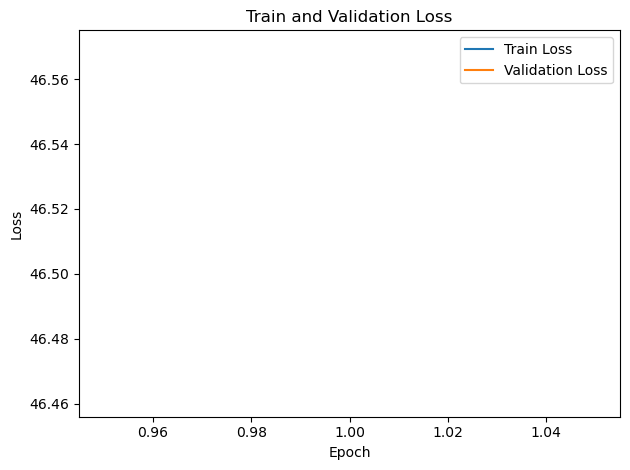

In [12]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
loss_list = train(model, model_params, timestamp)

In [13]:
print("Training output:")
for i in range(len(loss_list)):
    print(loss_list[i])

## Model saving

In [14]:
model_save_path = "trained_models/"
model_name_to_save = model_save_path + f"{model_params.get_model_code()}_{timestamp}.pth"
print(model_name_to_save)
torch.save(model.state_dict(), model_name_to_save)


# Test model (loading and inference)

Save results and export metrics to csv

In [15]:
model = SPmodel = SP_AffineNet().to(device)
print(model)

parameters = model.parameters()
optimizer = optim.Adam(parameters, model_params.learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: model_params.decay_rate ** epoch)

model.load_state_dict(torch.load(model_name_to_save))

Training output:
[1, 46.4614184529561, 46.56960289242081]
trained_models/11102_0.001_0_1_1_20231002-111944.pth
SP_AffineNet(
  (affineNet): AffineNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1s): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (conv2s): Conv2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
    (conv3s): Conv2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
    (conv4s): Conv2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
    (fc1): Linear(in_features=1024, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=32, bias=Tr

<All keys matched successfully>

In [16]:
def test(model, model_params, timestamp):
    # Set model to training mode
    model.eval()

    # Create output directory
    output_dir = f"output/{model_params.get_model_code()}_{timestamp}_test"
    os.makedirs(output_dir, exist_ok=True)

    # Validate model
    # validation_loss = 0.0

    # create a csv file to store the metrics
    csv_file = f"{output_dir}/metrics.csv"
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        # matches1_transformed.shape[-1], mse_before, mse12, tre_before, tre12, \
        # mse12_image, ssim12_image, 
        writer.writerow(["index", "mse_before", "mse12", "tre_before", "tre12", "mse12_image_before", "mse12_image", "ssim12_image_before", "ssim12_image"])

    with torch.no_grad():
        testbar = tqdm(test_dataset, desc=f'Testing:')
        for i, data in enumerate(testbar, 0):
            # Get images and affine parameters
            if model_params.sup:
                source_image, target_image, affine_params_true = data
            else:
                source_image, target_image = data
            source_image = source_image.to(device)
            target_image = target_image.to(device)

            # Forward pass
            outputs = model(source_image, target_image)
            # for i in range(len(outputs)):
            #     print(i, outputs[i].shape)
            transformed_source_affine = outputs[0]
            affine_params_predicted = outputs[1]
            points1 = outputs[2]
            points2 = outputs[3]
            points1_affine = np.array(outputs[4])
            try:
                points1_affine = points1_affine.reshape(points1_affine.shape[2], points1_affine.shape[1])
            except:
                pass
            desc1 = outputs[5]
            desc2 = outputs[6]
            heatmap1 = outputs[7]
            heatmap2 = outputs[8]

            output_file = f"{output_dir}/validation.txt"
            try: # need to do this because the warning cannot be suppressed, fix clipping makes the image all black
                # Open the file in append mode to save the print statements
                with open(output_file, 'a') as file:
                    # Redirect sys.stdout to the file
                    sys.stdout = file

                    # Redirect warnings to the file
                    # warnings.filterwarnings('always')  # Capture all warnings
                    warnings_file = open(output_file, 'a')
                    warnings.showwarning = lambda message, category, filename, lineno, file=warnings_file, line=None: \
                        file.write(warnings.formatwarning(message, category, filename, lineno, line))

                    # Plot images
                    with capture_output():
                        if i < 50:
                            plot_ = True
                        else:
                            plot_ = False

                        results = DL_affine_plot(f"{i+1}", output_dir,
                            f"{i}", "_", source_image[0, 0, :, :].cpu().numpy(), target_image[0, 0, :, :].cpu().numpy(), \
                            transformed_source_affine[0, 0, :, :].cpu().numpy(), \
                            points1, points2, points1_affine, desc1, desc2, \
                                affine_params=affine_params_predicted, heatmap1=heatmap1, heatmap2=heatmap2, plot=plot_)

                    # Reset sys.stdout to the console
                    sys.stdout = sys.__stdout__
                    warnings_file.close()
            except Exception as e:
                # Handle exceptions, if any
                print(f"An error occurred: {e}")

            # calculate metrics
            # matches1_transformed = results[0]
            mse_before = results[1]
            mse12 = results[2]
            tre_before = results[3]
            tre12 = results[4]
            mse12_image_before = results[5]
            mse12_image = results[6]
            ssim12_image_before = results[7]
            ssim12_image = results[8]

            # write metrics to csv file
            with open(csv_file, 'a', newline='') as file:
                writer = csv.writer(file) # TODO: might need to export true & predicted affine parameters too
                writer.writerow([i, mse_before, mse12, tre_before, tre12, mse12_image_before, mse12_image, ssim12_image_before, ssim12_image])

    # delete all txt files in output_dir
    for file in os.listdir(output_dir):
        if file.endswith(".txt"):
            os.remove(os.path.join(output_dir, file))

# timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
metrics = test(model, model_params, timestamp)

Testing::  67%|██████▋   | 146/217 [05:48<02:49,  2.39s/it]
